## Develop a machine learning model to predict the price of flight based on certain conditions/features

# Import the neccessary libraries

In [32]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,learning_curve,GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pickle
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
path ='Data_Train.xlsx'
data = pd.read_excel(path)


In [3]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Data Visualization

In [6]:

sns.set(style='whitegrid')

def visualize_categorical(data):
    features=['Airline','Source','Destination','Total_Stops']
    plt.figure(figsize=(15,12))
    for i,feature in enumerate(features):
        plt.subplot(2,3,i+1)
        sns.countplot(data,x=feature)
        plt.xlabel(feature)
        plt.ylabel('Value')
        plt.tight_layout()
        plt.xticks(rotation=90)
    plt.show()
    

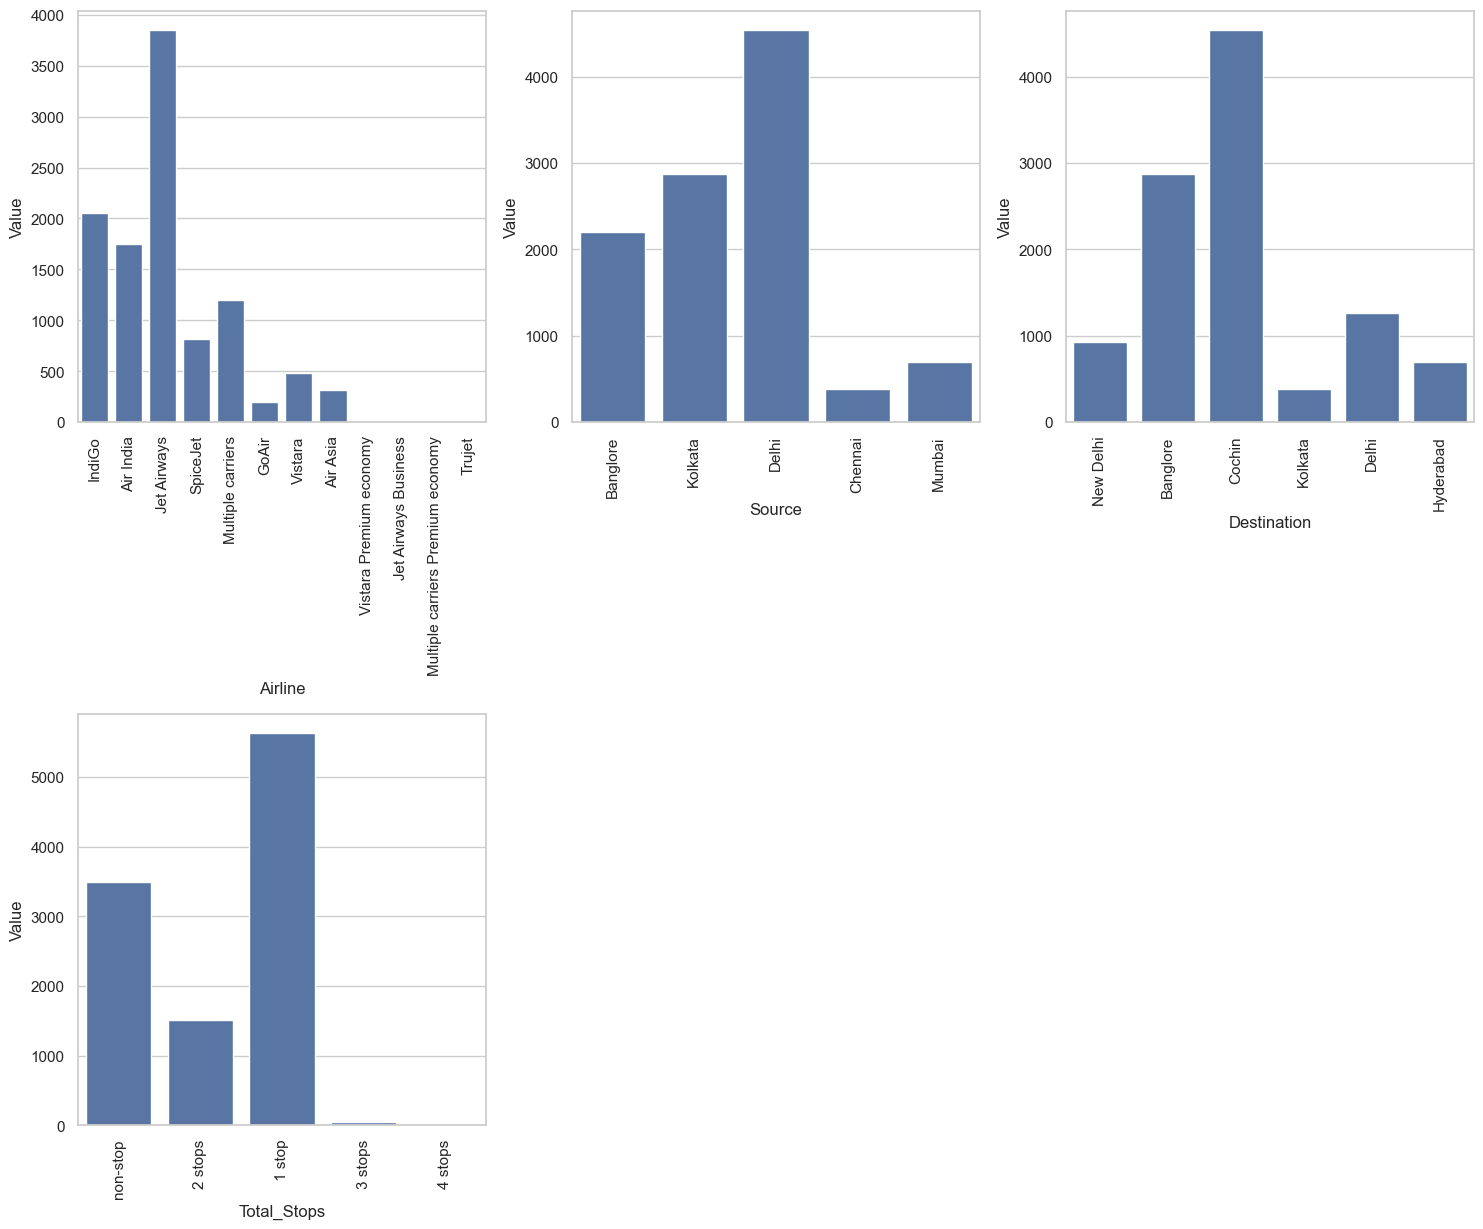

In [7]:
visualize_categorical(data)

In [8]:
# Bivariate Data Analysis for Categorical data

def categoricalvscategorical(data,data1,data2):
    features = ['Airline','Source','Destination']
    cross_tab = pd.crosstab(data[data1], data[data2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d')
    plt.title(data1 +' '+ 'vs' + ' ' + data2)
    plt.show()

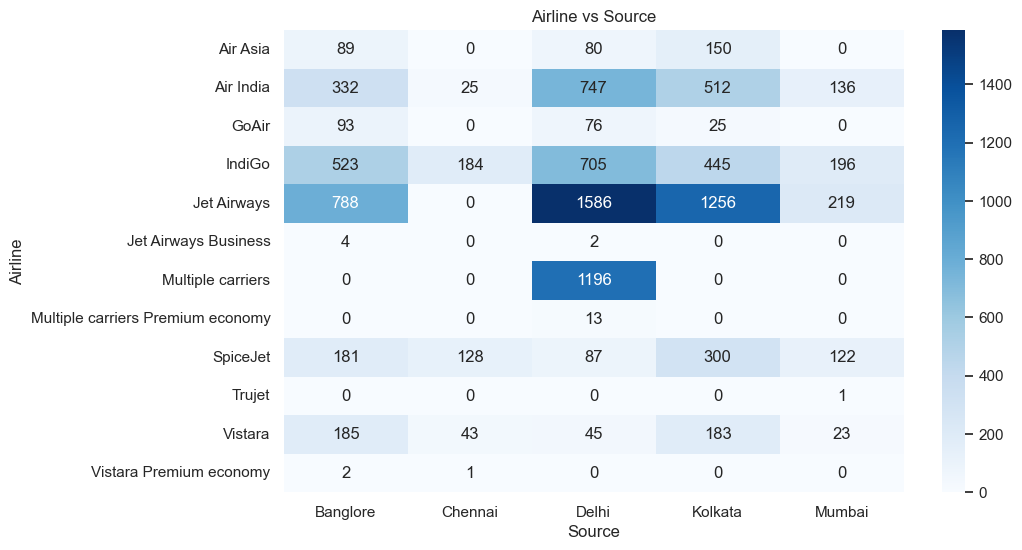

In [9]:
categoricalvscategorical(data,'Airline','Source')

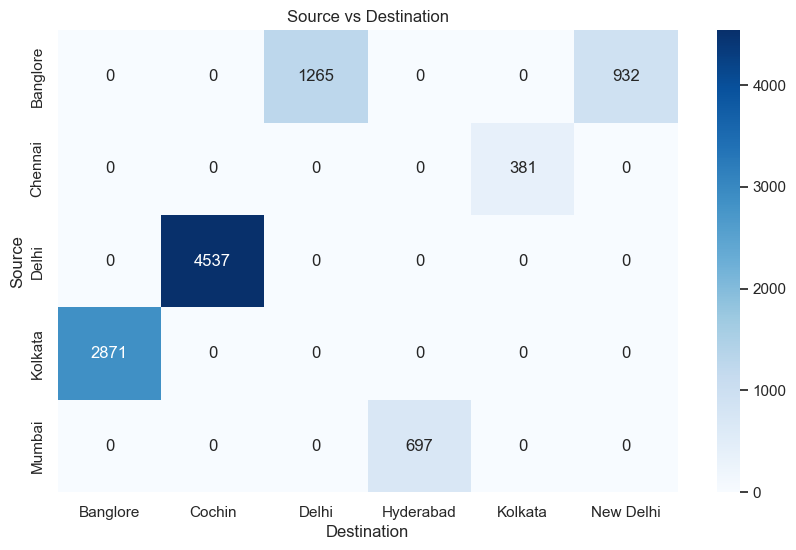

In [10]:
categoricalvscategorical(data,'Source','Destination')

# Data Cleaning

In [11]:
def clean_data(data):
    chk_null=data.isnull()
    chk_duplicate = data.duplicated()
    for n,d in zip(chk_null,chk_duplicate):
        if n==True:
            data=data.dropna()
        if d==True:
            data=data.drop_duplicated()
            print('Duplicated values removed')  
        else:
            print("Data is clean")

        return data.head(3)
    

In [12]:
clean_data(data)

Data is clean


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


# Feature Engineering

In [13]:
# convert the data of jouney column to datetime
features = ['Date_of_Journey','Duration']

def date_and_time(data):
     # Convert 'Date_of_Journey' to datetime
    data[features[0]]=pd.to_datetime(data[features[0]])
    
    # Convert 'Duration' to timedelta and remove '0 days' from the string representation
    data[features[1]]=pd.to_timedelta(data[features[1]])
    data[features[1]]=data['Duration'].astype(str).str.replace('0 days','')
      
    return data.head(3)

In [14]:
date_and_time(data)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,02:50:00,non-stop,No info,3897
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,07:25:00,2 stops,No info,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19:00:00,2 stops,No info,13882


In [15]:
# creating new features
#function to create new features year,month and day
def create_features():
    data['Year'] = data['Date_of_Journey'].dt.year
    data['Month'] = data['Date_of_Journey'].dt.month
    data['Day'] = data['Date_of_Journey'].dt.day
    return data.head(3)

In [16]:
create_features()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Year,Month,Day
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,02:50:00,non-stop,No info,3897,2019,3,24
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,07:25:00,2 stops,No info,7662,2019,5,1
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19:00:00,2 stops,No info,13882,2019,6,9


In [17]:
import re
# Function to extract hours and minutes
def extract_hours_minutes(time_str):
    # Check if 'days' is present and remove it
    days_match = re.search(r'(\d+) days?', time_str)
    if days_match:
        days = int(days_match.group(1))
        # Remove 'days' part from the string
        time_str = time_str.replace(days_match.group(0), '').strip()
    else:
        days = 0
    
    # Split the remaining time into hours and minutes
    hours, minutes,seconds= time_str.split(':')
    total_hours = int(hours) + (days * 24)
    minutes = int(minutes)
    seconds = int(seconds)
    
    return total_hours, minutes,seconds

# Apply the function to the DataFrame and create new columns
data[['Hours', 'Minutes','Seconds']] = data['Duration'].apply(lambda x: pd.Series(extract_hours_minutes(x)))




In [18]:
data.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Year,Month,Day,Hours,Minutes,Seconds
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,02:50:00,non-stop,No info,3897,2019,3,24,2,50,0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,07:25:00,2 stops,No info,7662,2019,5,1,7,25,0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19:00:00,2 stops,No info,13882,2019,6,9,19,0,0


In [19]:
# feature selection

new_data = data[['Airline','Source','Destination','Price','Hours','Minutes','Year','Month','Day']]
new_data.head()

,Airline,Source,Destination,Price,Hours,Minutes,Year,Month,Day
0,IndiGo,Banglore,New Delhi,3897,2,50,2019,3,24
1,Air India,Kolkata,Banglore,7662,7,25,2019,5,1
2,Jet Airways,Delhi,Cochin,13882,19,0,2019,6,9
3,IndiGo,Kolkata,Banglore,6218,5,25,2019,5,12
4,IndiGo,Banglore,New Delhi,13302,4,45,2019,3,1


In [20]:
new_data.columns

Index(['Airline', 'Source', 'Destination', 'Price', 'Hours', 'Minutes', 'Year',
       'Month', 'Day'],
      dtype='object')

In [21]:
# convert categorical data to  numerical data
features = ['Airline','Source','Destination']
le = LabelEncoder()
for i in features:
    new_data[i]=le.fit_transform(new_data[i])


In [22]:
X=new_data.drop(['Price'],axis=1)
y=new_data['Price']

In [23]:
# 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [25]:
# standard scaler: to scaler our dataset to have a mean of 0 and standard deviation of one

scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [28]:
# working with three algorithms
models={'LinearRegression':LinearRegression(),
       'DecisionTreeRegressor':DecisionTreeRegressor(),
       'RandomForestRegressor':RandomForestRegressor(random_state=42)}

In [33]:
for name,model in models.items():
    model.fit(X_train_scale,y_train)
    y_pred=model.predict(X_test_scale)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    measure=f'{name}: r2_score: {round(r2_score(y_test,y_pred),2)*100} MAE:{round(mean_absolute_error(y_test,y_pred),2)} MSE:{round(mean_squared_error(y_test,y_pred),2)} RMSE: {rmse}'
     # save the models
    filename = f'{name.lower()}_model.pk1'
    with open(filename,'wb') as f:
        pickle.dump(model,f)
    print(measure)
    

LinearRegression: r2_score: 30.0 MAE:2814.2 MSE:14761173.0 RMSE: 3842.027199561485
DecisionTreeRegressor: r2_score: 63.0 MAE:1610.14 MSE:7818224.52 RMSE: 2796.1088182287876
RandomForestRegressor: r2_score: 74.0 MAE:1423.73 MSE:5574359.07 RMSE: 2361.0080633026996


In [34]:
# a function to show how close the actual value are to the predicted value
def actual_predicted():
    plt.figure(figsize=(10,10))
    sns.scatterplot(x=y_test,y=y_pred)
    plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],color='red',linestyle='--')
    plt.title('Actual vs predicted values')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

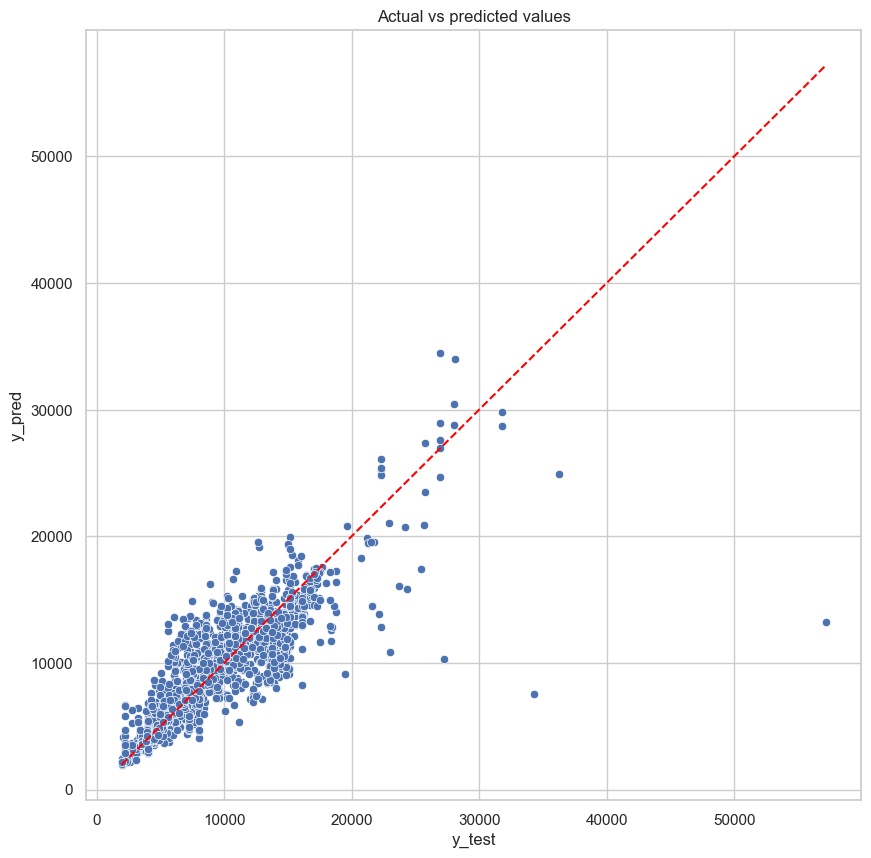

In [36]:
actual_predicted()

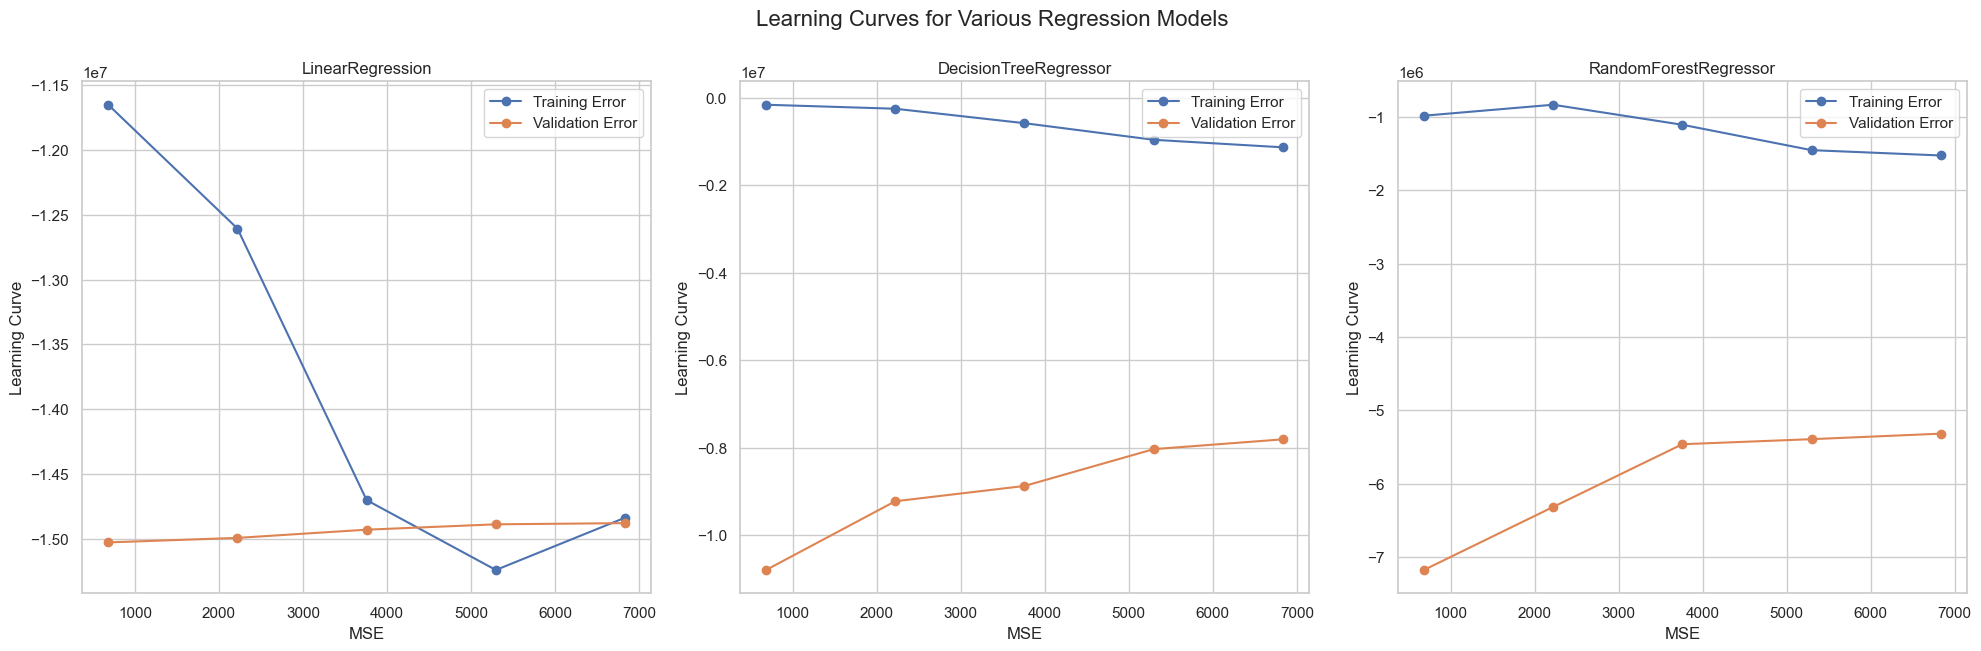

In [37]:
# plot the learning curve to visualize the perfoemance of our models and detect overfitting
plt.figure(figsize=(20,12))
for i,(name,model) in enumerate(models.items(),1):
    train_sizes,train_scores,test_scores = learning_curve(estimator=model,X=X_train_scale,y=y_train,train_sizes=np.linspace(0.1,1.0,5),cv=5,
                                                    scoring='neg_mean_squared_error')
    
    plt.subplot(2,3,i)
    plt.plot(train_sizes,train_scores.mean(axis=1),'o-',label='Training Error')
    plt.plot(train_sizes,test_scores.mean(axis=1), 'o-',label='Validation Error')
    plt.title(name)
    plt.xlabel('MSE')
    plt.ylabel('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
plt.tight_layout()
plt.suptitle('Learning Curves for Various Regression Models', fontsize=16)
plt.subplots_adjust(top=0.92)  # Adjust subplot params to give space for the main title
plt.show()
plt.show()

Analysis of Each Model
1. Linear Regressor

    Training Error: The training error decreases as the number of training samples increases, indicating that the model is learning from the data.
    
    Validation Error: The validation error decreases initially and then stabilizes, suggesting that adding more data does not significantly improve model performance.
    
    Interpretation: The gap between the training and validation errors suggests some generalization error, but the model is not severely overfitting. The linear regressor performs relatively well, but there's room for improvement.

2. Decision Tree Regressor

    Training Error: The training error remains low, close to zero, indicating that the model fits the training data almost perfectly.
    
    Validation Error: The validation error remains high and increases with more training samples.
    
    Interpretation: The large gap between the training and validation errors indicates overfitting. The decision tree model is likely too complex and captures noise in the training data, leading to poor generalization on the validation set.

3. Random Forest Regressor

    Training Error: The training error is relatively low, suggesting good performance on the training set.
    
    Validation Error: The validation error is higher than the training error but shows a decreasing trend as more training data is used.
    
    Interpretation: The smaller gap between the training and validation errors indicates better generalization compared to the Decision Tree Regressor. The model benefits from ensemble learning, which helps reduce overfitting.

Overall Conclusion
Linear Regressor: Good baseline model with a reasonable bias-variance trade-off.
Decision Tree Regressor: Prone to overfitting, as evidenced by the large gap between training and validation errors.
Random Forest Regressor: Shows the best generalization among the three models, with a good balance between bias and variance.

This visualization suggests that while all models have their strengths, the Random Forest Regressor may be the most reliable for this dataset due to its ability to generalize better. However, further tuning and testing are required to confirm this assessment and potentially improve the model's performance.